## GCN


---
This notebook implements a complete 10-fold cross-validation and final training workflow for a **Graph Convolutional Network (GCN)** on a regression task (e.g. continuous potency prediction).


**Prerequisites:**

* PyTorch & PyTorch Geometric
* scikit-learn
* pandas, numpy, matplotlib
* RDKit (only for feature extraction)
* GPU recommended

**Install requirements:**

pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi

1. **Environment & Setup**

     Seed all random generators for reproducibility.

    Define paths for data splits and output.

    Detect GPU/CPU.

2. **Model Definition**  
   Define a simple 2-layer GCN with dropout and a global mean-pooling head.

3. **Evaluation Function**  
   `evaluate(model, loader)` returns concatenated predictions and true targets.

4. **Hyperparameter Sweep (10-Fold CV)**  
   - Grid search over **hidden_dim**, **dropout**, **learning_rate**  
   - For each config, run 10-fold CV:  
     - Train each fold for 50 epochs  
     - Compute per-fold metrics on the validation set:  
       - MAE, MSE, RMSE, R²  
   - Aggregate mean ± std across folds and display top configurations.

5. **Retrain & CV Summary (10-Fold)**  
   - Retrain each fold with the best hyperparameters and early stopping  
   - Save each fold’s best model  
   - Compute and save per-fold **MAE**, **MSE**, **RMSE**, **R²** to `crossval_summary_reg.csv`.

6. **Cross-Validation Results Visualization**  
   - Load `crossval_summary_reg.csv`  
   - Plot bar charts of MAE, MSE, RMSE, R² across folds  
   - Print mean ± std for each metric.

7. **Ensemble Averaging on Test Set**  
   - Load all 10 fold checkpoints  
   - Run on the hold-out test set, average predictions  
   - Compute and report ensemble MAE, MSE, RMSE, R²  
   - Scatter plot: true vs. ensemble-predicted values.

8. **Final Model Training & Test Evaluation**  
   - Merge all train+val folds, hold out 10% for validation  
   - Train final GCN with early stopping & LR scheduler  
   - Save `gcn_final_model_reg.pt`  
   - Evaluate on the test set: MAE, MSE, RMSE, R²  
   - Save `gcn_final_metrics_reg.csv`, plus final scatter & regression plots.

9. **Baseline Comparison (Optional)**  
   - Load baseline QSAR metrics  
   - Compare side-by-side in a table or bar chart.

In [1]:
pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29

In [2]:
# Step 1: Mount Drive & Imports
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
## 1. Imports & Setup

import os, random
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# Seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark    = False

def seed_worker(worker_id):
    ws = seed + worker_id
    np.random.seed(ws)
    random.seed(ws)

generator = torch.Generator().manual_seed(seed)
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths & Task
root_dir    = "/content/drive/MyDrive/GNN_model_TRPM8_Drug_Potency_prediction/GNN_model_TRPM8_Drug_Potency_prediction-Dolapo"
base_path   = os.path.join(root_dir, "4_train_test_split/10fold_cv/regression")
results_dir = os.path.join(root_dir, "GCN_results/regression_10fold")
os.makedirs(results_dir, exist_ok=True)

task    = "regression"
kfold   = 10

In [6]:
# Step 2: GCN Regression Model
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.0):
        super().__init__()
        self.conv1   = GCNConv(in_dim, hidden_dim)
        self.conv2   = GCNConv(hidden_dim, hidden_dim)
        self.dropout = dropout
        self.lin     = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x).squeeze(-1)


In [7]:
# Step 3: Evaluation Helper
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out   = model(batch)
            preds.append(out.cpu())
            targets.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(targets)


In [10]:
# Step 4: Hyperparameter Sweep (10-Fold CV)
#Input dimensions and device
sample_data = torch.load(
    os.path.join(base_path, "regression_train_fold0.pt"),
    weights_only=False
)
sample      = sample_data[0]
in_dim      = sample.x.size(1)
out_dim     = 1
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Input dim:", in_dim, "| Device:", device)


Input dim: 19 | Device: cpu


In [12]:
# Hyperparameter sweep
hidden_dims = [64,128,256]
dropouts    = [0.0,0.2,0.4]
lrs         = [1e-3,5e-4,1e-4]

sweep = []
print(" Starting hyperparameter sweep")
for hd in hidden_dims:
    for dp in dropouts:
        for lr in lrs:
            r2_scores = []
            for fold in range(10):
                # load data
                tr = torch.load(os.path.join(base_path, f"regression_train_fold{fold}.pt"), weights_only=False)
                vl = torch.load(os.path.join(base_path, f"regression_val_fold{fold}.pt"),   weights_only=False)
                tr_loader = DataLoader(tr, batch_size=32, shuffle=True)
                vl_loader = DataLoader(vl, batch_size=32)

                # model & optimizer
                model = GCN(in_dim, hd, out_dim, dropout=dp).to(device)
                opt   = torch.optim.Adam(model.parameters(), lr=lr)

                # train 50 epochs
                for epoch in range(50):
                    model.train()
                    for b in tr_loader:
                        b = b.to(device)
                        opt.zero_grad()
                        loss = F.mse_loss(model(b).squeeze(), b.y)
                        loss.backward()
                        opt.step()

                # val
                preds, trues = evaluate(model, vl_loader)
                r2_scores.append(r2_score(trues.numpy(), preds.numpy()))

            mean_r2 = np.mean(r2_scores)
            std_r2  = np.std(r2_scores)
            sweep.append({
                "hidden_dim":   hd,
                "dropout":      dp,
                "lr":           lr,
                "mean_r2":      mean_r2,
                "std_r2":       std_r2
            })
            print(f"hd={hd} dp={dp} lr={lr} → R²={mean_r2:.4f}±{std_r2:.4f}")

sweep_df = pd.DataFrame(sweep).sort_values("mean_r2", ascending=False)
sweep_df.to_csv(os.path.join(results_dir, "gcn_reg_sweep.csv"), index=False)
display(sweep_df.head())


 Starting hyperparameter sweep
hd=64 dp=0.0 lr=0.001 → R²=0.0860±0.1295
hd=64 dp=0.0 lr=0.0005 → R²=0.0119±0.1683
hd=64 dp=0.0 lr=0.0001 → R²=-0.0147±0.1640
hd=64 dp=0.2 lr=0.001 → R²=0.0958±0.1287
hd=64 dp=0.2 lr=0.0005 → R²=0.0193±0.1517
hd=64 dp=0.2 lr=0.0001 → R²=-0.0146±0.1444
hd=64 dp=0.4 lr=0.001 → R²=0.0856±0.1505
hd=64 dp=0.4 lr=0.0005 → R²=0.0287±0.1492
hd=64 dp=0.4 lr=0.0001 → R²=-0.0013±0.1296
hd=128 dp=0.0 lr=0.001 → R²=0.0886±0.1806
hd=128 dp=0.0 lr=0.0005 → R²=0.0609±0.1632
hd=128 dp=0.0 lr=0.0001 → R²=-0.0010±0.1528
hd=128 dp=0.2 lr=0.001 → R²=0.1362±0.0910
hd=128 dp=0.2 lr=0.0005 → R²=0.0560±0.1569
hd=128 dp=0.2 lr=0.0001 → R²=0.0019±0.1389
hd=128 dp=0.4 lr=0.001 → R²=0.0746±0.2346
hd=128 dp=0.4 lr=0.0005 → R²=0.0687±0.1499
hd=128 dp=0.4 lr=0.0001 → R²=0.0010±0.1392
hd=256 dp=0.0 lr=0.001 → R²=0.1681±0.1228
hd=256 dp=0.0 lr=0.0005 → R²=0.0928±0.1131
hd=256 dp=0.0 lr=0.0001 → R²=0.0016±0.1550
hd=256 dp=0.2 lr=0.001 → R²=0.0737±0.3486
hd=256 dp=0.2 lr=0.0005 → R²=0.0933±

,hidden_dim,dropout,lr,mean_r2,std_r2
18,256,0.0,0.0010,0.168119,0.122755
24,256,0.4,0.0010,0.139618,0.067671
12,128,0.2,0.0010,0.136188,0.091013
3,64,0.2,0.0010,0.095848,0.128734
22,256,0.2,0.0005,0.093309,0.218152


In [13]:
# Select the best hyperparameters
best = sweep_df.iloc[0]
best_hd  = int(best.hidden_dim)
best_dp  = float(best.dropout)
best_lr  = float(best.lr)
print("Best:", best_hd, best_dp, best_lr)


Best: 256 0.0 0.001


In [14]:
# Step 5: Retrain Folds & CV Summary
fold_metrics = []
for fold in range(10):
    print(f" Fold {fold+1}/10")
    tr = torch.load(os.path.join(base_path, f"regression_train_fold{fold}.pt"), weights_only=False)
    vl = torch.load(os.path.join(base_path, f"regression_val_fold{fold}.pt"),   weights_only=False)
    tr_loader = DataLoader(tr, batch_size=32, shuffle=True)
    vl_loader = DataLoader(vl, batch_size=32)

    model = GCN(in_dim, best_hd, out_dim, dropout=best_dp).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=best_lr)

    best_vloss, patience = float("inf"), 0
    for epoch in range(1,301):
        model.train()
        tot = 0
        for b in tr_loader:
            b = b.to(device)
            opt.zero_grad()
            out = model(b).squeeze()
            loss = F.mse_loss(out, b.y)
            loss.backward()
            opt.step()
            tot += loss.item()

        # val
        preds, trues = evaluate(model, vl_loader)
        vloss = F.mse_loss(preds, trues).item()

        if vloss < best_vloss:
            best_vloss, patience = vloss, 0
            torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience += 1
            if patience >= 10:
                print(" Early stopping")
                break

    y_p = preds.numpy()
    y_t = trues.numpy()
    mae  = mean_absolute_error(y_t, y_p)
    mse  = mean_squared_error(y_t, y_p)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_t, y_p)

    fold_metrics.append({
        "fold": fold+1,
        "mae":  mae,
        "mse":  mse,
        "rmse": rmse,
        "r2":   r2
    })

cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary_reg.csv"), index=False)
print(" Saved CV summary")
display(cv_df)


 Fold 1/10
 Early stopping
 Fold 2/10
 Early stopping
 Fold 3/10
 Early stopping
 Fold 4/10
 Early stopping
 Fold 5/10
 Early stopping
 Fold 6/10
 Early stopping
 Fold 7/10
 Early stopping
 Fold 8/10
 Early stopping
 Fold 9/10
 Early stopping
 Fold 10/10
 Early stopping
 Saved CV summary


,fold,mae,mse,rmse,r2
0,1,0.792537,1.056086,1.027661,0.159691
1,2,0.747516,0.830817,0.911492,0.332295
2,3,0.931555,1.403724,1.184789,-0.506609
3,4,0.671877,0.690233,0.830803,0.409859
4,5,0.710731,0.739130,0.859727,0.414898
5,6,0.704979,0.871158,0.933358,0.338743
6,7,0.848961,0.991579,0.995781,0.312780
7,8,0.662829,0.752985,0.867747,0.292493
8,9,0.869282,1.305686,1.142666,0.016355
9,10,0.829280,0.974153,0.986992,0.407012


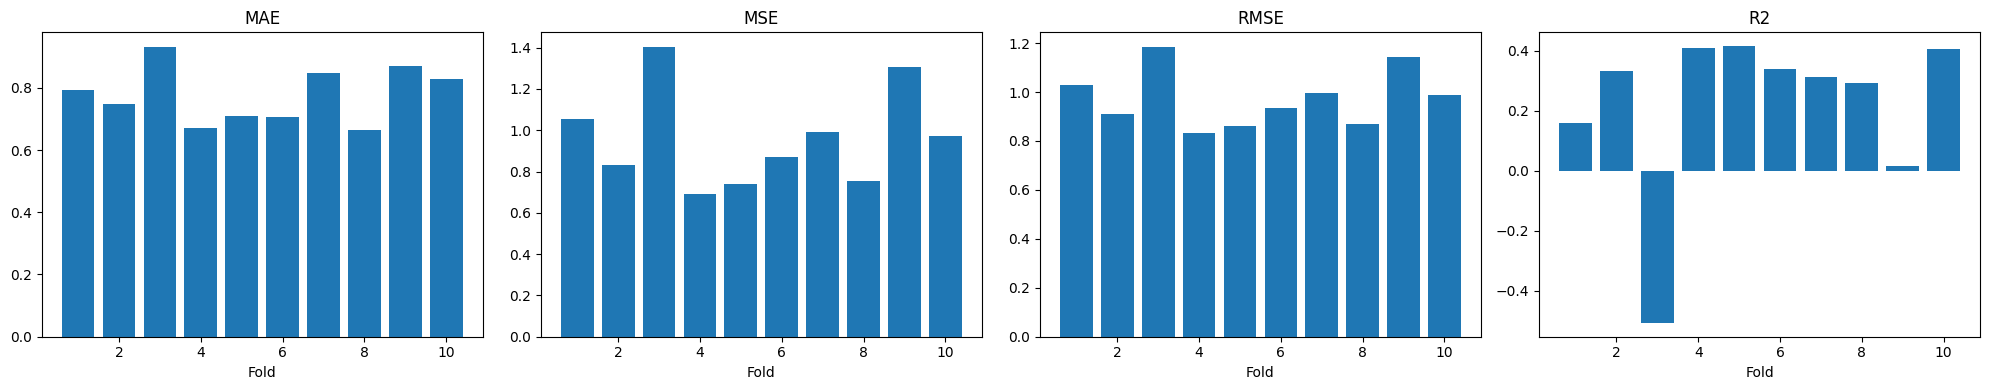

In [15]:
# Step 6: Visualize CV Results
cv_df = pd.read_csv(os.path.join(results_dir, "crossval_summary_reg.csv"))
metrics = ["mae","mse","rmse","r2"]
fig, axs = plt.subplots(1, len(metrics), figsize=(20,4))
for i, m in enumerate(metrics):
    axs[i].bar(cv_df["fold"], cv_df[m])
    axs[i].set_title(m.upper())
    axs[i].set_xlabel("Fold")
plt.tight_layout()
plt.show()


Ensemble → MAE=0.7496, RMSE=0.9424, R2=0.3316


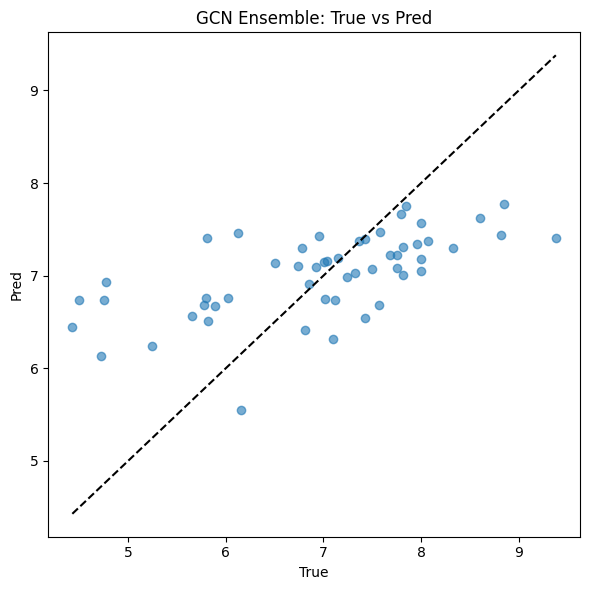

In [16]:
# Step 7: Ensemble averaging on test set

test_data = torch.load(os.path.join(base_path, "regression_test.pt"), weights_only=False)
test_loader = DataLoader(test_data, batch_size=32)

all_preds = []
for fold in range(10):
    m = GCN(in_dim, best_hd, out_dim, dropout=best_dp).to(device)
    m.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    m.eval()
    preds = []
    with torch.no_grad():
        for b in test_loader:
            preds.append(m(b.to(device)).cpu().squeeze())
    all_preds.append(torch.cat(preds))

avg_preds = torch.stack(all_preds).mean(0)
y_true    = torch.cat([d.y for d in test_data]).numpy()
y_pred    = avg_preds.numpy()

# metrics
mae_e  = mean_absolute_error(y_true, y_pred)
mse_e  = mean_squared_error(y_true, y_pred)
rmse_e = np.sqrt(mse_e)
r2_e   = r2_score(y_true, y_pred)

# save preds
pd.DataFrame({"True": y_true, "Pred": y_pred})\
  .to_csv(os.path.join(results_dir, "gcn_ensemble_preds_reg.csv"), index=False)

print(f"Ensemble → MAE={mae_e:.4f}, RMSE={rmse_e:.4f}, R2={r2_e:.4f}")

# scatter
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],[y_true.min(), y_true.max()],"k--")
plt.xlabel("True")
plt.ylabel("Pred")
plt.title("GCN Ensemble: True vs Pred")
plt.tight_layout()
plt.show()


Final → {'mae': 0.6850417256355286, 'mse': 0.8199118375778198, 'rmse': np.float64(0.9054898329511049), 'r2': 0.38293665647506714}


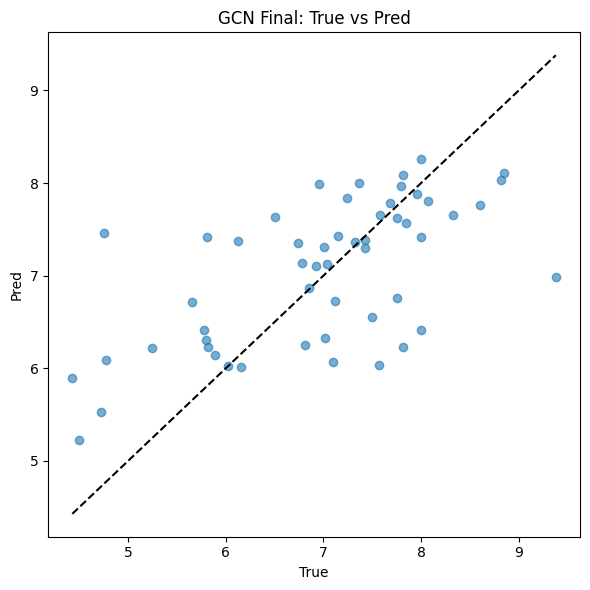

In [17]:
# Step 8: # merge all train+val
all_data = []
for f in range(10):
    all_data += torch.load(os.path.join(base_path, f"regression_train_fold{f}.pt"), weights_only=False)
    all_data += torch.load(os.path.join(base_path, f"regression_val_fold{f}.pt"),   weights_only=False)

# hold-out 10%
train_split, val_split = train_test_split(
    all_data, test_size=0.1, random_state=seed
)
tr_loader = DataLoader(train_split, batch_size=32, shuffle=True)
vl_loader = DataLoader(val_split,   batch_size=32)

model = GCN(in_dim, best_hd, out_dim, dropout=best_dp).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=best_lr)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=5, factor=0.5)

best_vloss, patience = float("inf"), 0
for epoch in range(1,301):
    model.train()
    tot=0
    for b in tr_loader:
        b=b.to(device)
        opt.zero_grad()
        out= model(b).squeeze()
        loss=F.mse_loss(out, b.y)
        loss.backward(); opt.step()
        tot+=loss.item()

    preds, trues = evaluate(model, vl_loader)
    vloss = F.mse_loss(preds, trues).item()
    sched.step(vloss)

    if vloss<best_vloss:
        best_vloss,patience=vloss,0
        torch.save(model.state_dict(), os.path.join(results_dir, "gcn_final_model_reg.pt"))
    else:
        patience+=1
        if patience>=10:
            break

# test eval
model.load_state_dict(torch.load(os.path.join(results_dir, "gcn_final_model_reg.pt")))
test_ld = DataLoader(torch.load(os.path.join(base_path, "regression_test.pt"), weights_only=False), batch_size=32)
preds, trues = evaluate(model, test_ld)
y_p, y_t = preds.numpy(), trues.numpy()

mae_f  = mean_absolute_error(y_t, y_p)
mse_f  = mean_squared_error(y_t, y_p)
rmse_f = np.sqrt(mse_f)
r2_f   = r2_score(y_t, y_p)

final_metrics = {"mae":mae_f, "mse":mse_f, "rmse":rmse_f, "r2":r2_f}
pd.DataFrame(final_metrics, index=[0])\
  .to_csv(os.path.join(results_dir, "gcn_final_metrics_reg.csv"), index=False)
print("Final →", final_metrics)

# scatter
plt.figure(figsize=(6,6))
plt.scatter(y_t, y_p, alpha=0.6)
plt.plot([y_t.min(), y_t.max()],[y_t.min(), y_t.max()],"k--")
plt.xlabel("True"); plt.ylabel("Pred")
plt.title("GCN Final: True vs Pred")
plt.tight_layout()
plt.show()
